In [22]:
#Importing Important Libraries
%matplotlib inline
import torch
import torch.nn as nn
from torchvision import datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import random

In [23]:
# Load MNIST from file
DATA_DIR = "."
download_dataset = False

train_mnist = datasets.MNIST(DATA_DIR, train=True, download=download_dataset)
test_mnist = datasets.MNIST(DATA_DIR, train=False, download=download_dataset)

In [24]:
print(train_mnist)
print(test_mnist)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test


In [25]:
len(train_mnist)

60000

In [26]:
len(test_mnist)

10000

In [27]:
# Create variables for MNIST data
X_train = train_mnist.data.float()
y_train = train_mnist.targets
X_test = test_mnist.data.float()
y_test = test_mnist.targets

Displaying train and test samples and Images

In [28]:
print(len(X_train))
print(len(y_train))

60000
60000


In [29]:
print(X_train[0].shape)
print(y_train[0].shape)

torch.Size([28, 28])
torch.Size([])


In [30]:
print(len(X_test))
print(len(y_test))

10000
10000


In [31]:
print(X_test[0].shape)
print(y_test[0].shape)

torch.Size([28, 28])
torch.Size([])


In [33]:
X_train[0]

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,

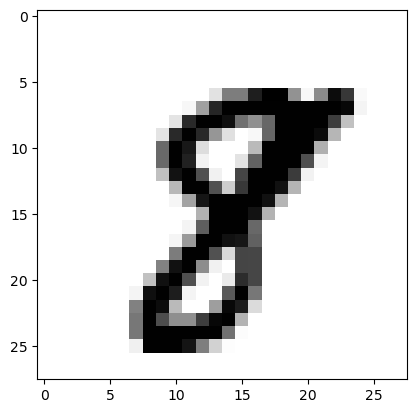

In [34]:
plt.imshow(X_train[55],cmap='binary')

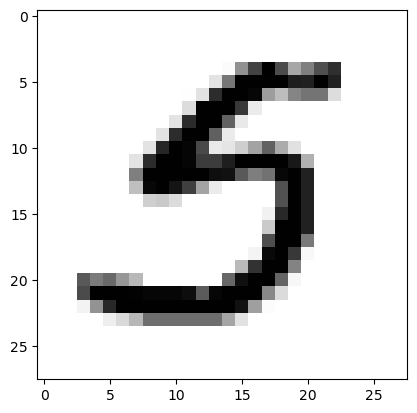

In [35]:
plt.imshow(X_train[699],cmap='binary')

In [36]:
y_train[55]

tensor(8)

In [37]:
y_train[699]

tensor(5)

Preparing Data for Model

In [38]:
X_train.shape

torch.Size([60000, 28, 28])

In [39]:
X_test.shape

torch.Size([10000, 28, 28])

In [40]:
# Random Sampling for validation Set
test_size = X_test.shape[0]
indices = np.random.choice(X_train.shape[0], test_size, replace=False)

# Creating the validation set
X_valid = X_train[indices]
y_valid = y_train[indices]

# Removing Validation set from training set
X_train = np.delete(X_train, indices, axis=0)
y_train = np.delete(y_train, indices, axis=0)

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([50000, 28, 28])
torch.Size([50000])
torch.Size([10000, 28, 28])
torch.Size([10000])
torch.Size([10000, 28, 28])
torch.Size([10000])


IMAGE VECTORIZATION - CONVERTING MATRIXES INTO VECTORS

In [44]:
X_train_flat = X_train.reshape(len(X_train), 28*28)
X_valid_flat = X_valid.reshape(len(X_valid), 28*28)
X_test_flat = X_test.reshape(len(X_valid), 28*28)

In [45]:
#Storing number of features
n_feat = X_train.shape[1]

print(X_train_flat.shape)
print(X_valid_flat.shape)
print(X_test_flat.shape)

torch.Size([50000, 784])
torch.Size([10000, 784])
torch.Size([10000, 784])


BUILDING THE ANN NUERAL NETWORK CLASSIFICATION MODEL

In [48]:
class AnnModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 64)
    self.linear2 = nn.Linear(64, 32)
    self.linear3 = nn.Linear(32, 16)
    self.linear4 = nn.Linear(16, output_size)
  
  def forward(self, x_batch):
    outputs = x_batch
    #Using ReLu method there to map all negative values to 0 to increase the effectiveness of the model
    outputs = self.linear4(F.relu(self.linear3(F.relu(self.linear2(F.relu(self.linear1(outputs)))))))
    return outputs

BUILDING ACCURACY AND LOSS FUNCTIONS FOR THE MODEL

In [49]:
def accuracy_score(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  correct_preds = torch.sum(preds==labels).item()
  total_preds = len(preds)
  accuracy = torch.tensor(correct_preds/total_preds)
  return accuracy

DEFINING VALIDATION FUNCTIONS

In [50]:
def validation_step(model, batch):
  images, labels = batch
  loss = F.cross_entropy(model.forward(images), labels)
  acc = accuracy_score(model.forward(images), labels)
  return {'val_loss':loss, 'val_acc':acc}

def validation_epoch_end(outputs):  
  batch_losses = [x['val_loss'] for x in outputs]
  epoch_loss = torch.stack(batch_losses).mean()
  batch_accs = [x['val_acc'] for x in outputs]
  epoch_acc = torch.stack(batch_accs).mean()
  return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

def evaluate(model, val_loader):
  metrics = [validation_step(model, batch) for batch in val_loader]
  metrics = validation_epoch_end(metrics)
  return metrics